In [1]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# load vic parameter file
vic_param = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_params_Modis_calibrated_Indus.nc')
# print out the variable names
print(f'vic_parameter file has following variables: \n {vic_param.variables.keys()}\n')
domain = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/domain_Indus.nc') #load mask file
mask = np.flip(domain.variables['mask'][:],axis = 0).mask # 

vic_parameter file has following variables: 
 dict_keys(['AreaFract', 'Nelev', 'Pfactor', 'elev', 'elevation', 'lat', 'lon', 'snow_band', 'Ds', 'Dsmax', 'Ws', 'c', 'infilt', 'annual_prec', 'avg_T', 'run_cell', 'Cv', 'LAI', 'Nveg', 'RGL', 'albedo', 'displacement', 'fcanopy', 'month', 'overstory', 'rad_atten', 'rarc', 'rmin', 'root_depth', 'root_fract', 'root_zone', 'trunk_ratio', 'veg_class', 'veg_rough', 'wind_atten', 'wind_h', 'b_co2', 'Ksat', 'Nlayer', 'Wcr_FRACT', 'Wfc_FRACT', 'Wpwp_FRACT', 'bubble', 'bulk_density', 'depth', 'dp', 'expt', 'fs_active', 'init_moist', 'phi_s', 'quartz', 'resid_moist', 'rough', 'snow_rough', 'soil_density'])



plot the Ksat to check what area might have capillary rise

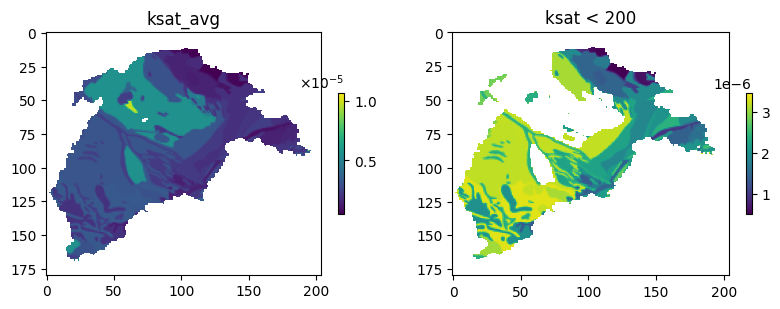

In [3]:
# load the ksat parameter
ksat = vic_param.variables['Ksat'][:]
# split the ksat into 3 layers and do unit conversion from mm/day to m/s

ksat_layer1 = ksat[0, :, :] / (1000 * 24 * 3600)
ksat_layer2 = ksat[1, :, :] / (1000 * 24 * 3600)
ksat_layer3 = ksat[2, :, :] / (1000 * 24 * 3600)
# do an average of the 3 layers
ksat_avg =( (ksat_layer1 + ksat_layer2 + ksat_layer3) / 3).data
ksat_avg[mask] = np.nan
ksat200 = ksat_avg.copy()
ksat200[ksat200 > 300/1000/24/3600] = np.nan

#subplots ksat_avg, ksat200
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(ksat_avg)
ax[0].set_title('ksat_avg')
fig.colorbar(ax[0].imshow(ksat_avg), ax=ax[0], orientation='vertical',  format=ticker.ScalarFormatter(useMathText=True),shrink=0.5  )

ax[1].imshow(ksat200)
ax[1].set_title('ksat < 200')
import matplotlib.ticker as ticker

fig.colorbar(ax[1].imshow(ksat200), ax=ax[1], orientation='vertical', fraction=.1, format=ticker.ScalarFormatter(useMathText=False),shrink=0.5   )

plt.tight_layout()
plt.show()




<class 'numpy.ndarray'>


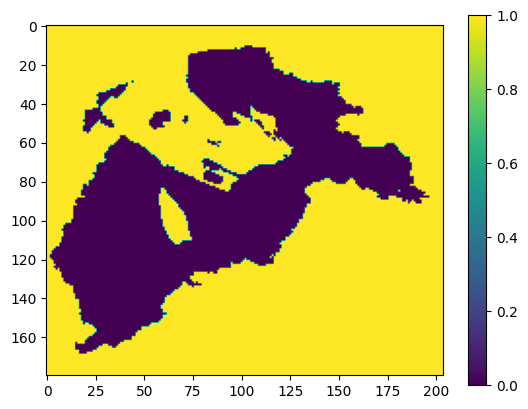

In [4]:
# create a maskarray from ksat200
ksat200_mask = np.ma.masked_array(ksat200, mask=np.isnan(ksat200)).mask
plt.imshow(ksat200_mask)
plt.colorbar()
print(type(ksat200_mask))

calculate the effective porosity n = bulk_density/soil_density


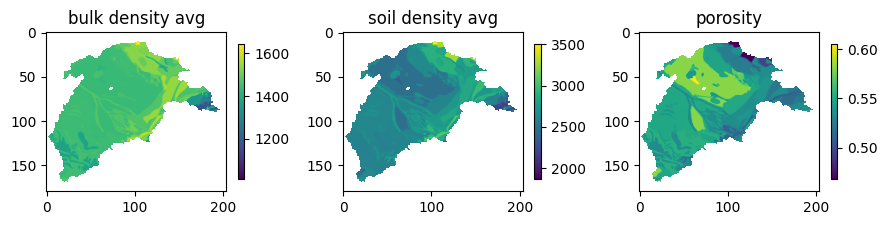

In [5]:
bulk_density = vic_param.variables['bulk_density']
bulk_density=np.flip(bulk_density,axis=0)
bulk_density1 = bulk_density[0, :, :]
bulk_density2 = bulk_density[1, :, :]
bulk_density3 = bulk_density[2, :, :]
bulk_density_avg = ((bulk_density1 + bulk_density2 + bulk_density3) / 3).data
bulk_density_avg[mask] = np.nan

soil_density = vic_param.variables['soil_density']
soil_density1 = soil_density[0, :, :]
soil_density2 = soil_density[1, :, :]
soil_density3 = soil_density[2, :, :]
soil_density_avg = ((soil_density1 + soil_density2 + soil_density3) / 3).data

soil_density_avg[mask] = np.nan
porosity = bulk_density_avg / soil_density_avg
porosity1 = bulk_density1 / soil_density1
porosity2 = bulk_density2 / soil_density2
porosity3 = bulk_density3 / soil_density3



fig, ax = plt.subplots(1, 3, figsize=(9, 3))
im0 = ax[0].imshow(bulk_density_avg)
ax[0].set_title('bulk density avg')
fig.colorbar(im0, ax=ax[0],shrink=0.5)

im1 = ax[1].imshow(soil_density_avg)
ax[1].set_title('soil density avg')
fig.colorbar(im1, ax=ax[1],shrink=0.5)

im2 = ax[2].imshow(porosity)
ax[2].set_title('porosity')
fig.colorbar(im2, ax=ax[2],shrink=0.5)

plt.tight_layout()
plt.show()

In [6]:
#calculate max_moist as pososity * depth

print(bulk_density.shape)

porosity_3 = bulk_density / soil_density



depth = vic_param.variables['depth']
depth = np.flip(depth,axis=1)
max_moist = porosity_3 * depth *1000

print(max_moist.shape)

max_moist[0][mask] = np.nan
max_moist[1][mask] = np.nan
max_moist[2][mask] = np.nan
porosity_3[0][mask] = np.nan 
porosity_3[1][mask] = np.nan
porosity_3[2][mask] = np.nan




(3, 180, 204)
(3, 180, 204)


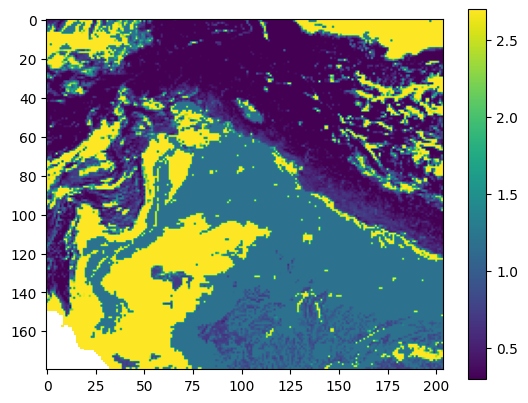

In [7]:
plt.imshow(depth[1])
plt.colorbar()

In [8]:
max_moist = np.flip(max_moist,axis=1)
porosity_3 = np.flip(porosity_3,axis=1)


#open parameter file and write max_moist and porosity to it
with nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_derived_param_for_coupling.nc','a') as ds:
    #create a new dimension layer
    #ds.createDimension('lay', 3)
    #create a new variable
    #ds.createVariable('max_moist', 'f4', ('lay', 'lat', 'lon',))
    #ds.createVariable('porosity', 'f4', ('lay', 'lat', 'lon',))
    #write 3 layser max_moist to the file
    ds.variables['max_moist'][:] = max_moist
    ds.variables['porosity'][:] = porosity_3
    

In [9]:
max_moist[0,:,:].shape
max1 = max_moist[0,:,:]
print(type(max1))

<class 'numpy.ma.core.MaskedArray'>


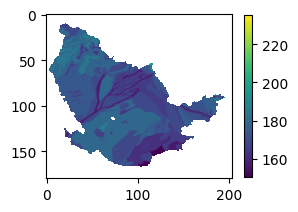

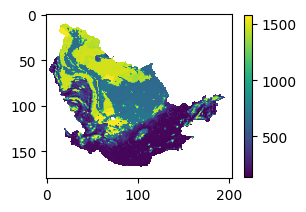

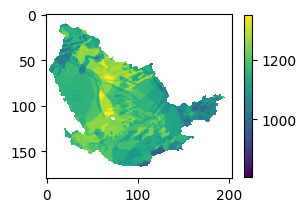

In [10]:
for i in range(3):
    plt.figure(figsize= (3,3))
    plt.imshow(max_moist[i,:,:].data)
    plt.colorbar(shrink=0.7)
    plt.show()

CPsurface has 15167 non-nan values
max depth is 2.536641397169828
min depth is 2.0184067477595584
max CPsurface is 6162.756475754599
min CPsurface is -2.0660883658684575
<class 'numpy.ma.core.MaskedArray'>


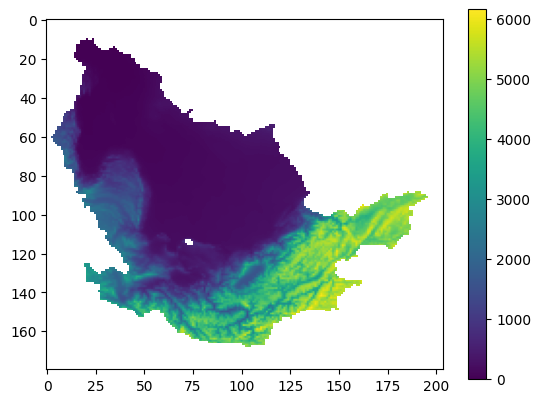

In [11]:
import netCDF4 as nc
import os
surface = vic_param.variables['elev'][:]
surface = np.flip(surface,axis=0)
surface[mask] = np.nan

depth = vic_param.variables['depth'][2, :, :]
depth = np.flip(depth,axis=0)
depth[mask] = np.nan
CPsurface = surface - depth
CPsurface = np.flip(CPsurface,axis = 0)

plt.imshow(CPsurface)
print(f'CPsurface has {np.count_nonzero(~np.isnan(CPsurface))} non-nan values')
print(f'max depth is {np.nanmax(depth)}')
print(f'min depth is {np.nanmin(depth)}')
print(f'max CPsurface is {np.nanmax(CPsurface)}')
print(f'min CPsurface is {np.nanmin(CPsurface)}')
plt.colorbar()
print(type(CPsurface))



estimate hc


min hc is 1.5063829003760536 m
max hc is 5.410660576344763 m


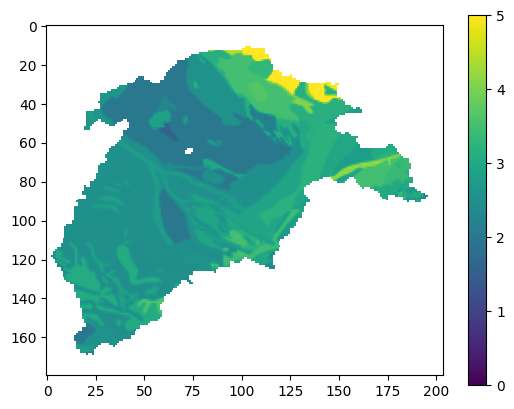

In [12]:
import numpy as np

sigma = (0.0742+0.0728)/2 # suface tension of water at 15 degree C
g = 9.81 # gravity
rho = 999.06 # density of water at 15 degree C
eta = 1.1375*0.001 # viscosity of water at 15 degree C
ha = 0.25 # average air entry suction head
hc = sigma * porosity / np.sqrt(2 * eta * rho * g * ksat_avg) * 0.5 + (1 - porosity) * ha
plt.imshow(hc,vmin = 0, vmax = 5)
plt.colorbar()
#setup min and max for colorbar
hcmin = np.nanmin(hc)
hcmax = np.nanmax(hc)
print(f'min hc is {hcmin} m')
print(f'max hc is {hcmax} m')

#print(sigma/np.sqrt(2 * eta * rho * g ))
from math import cos
from math import pi

sigma = 0.0728
g = 9.81
rho = 998.2
eta = 1.0016*0.001
#print(sigma/np.sqrt(2 * eta * rho * g ))
#print((sigma*0.408*cos(53.3*pi/180)  / np.sqrt(2 * eta * rho * g*0.15))+(1-0.408)*0.15)
#print((0.0164*0.408*cos(53.3*pi/180)  / np.sqrt(0.15))+(1-0.408)*0.15)


according to Malik 1989    
now we estimate the max capillary flux


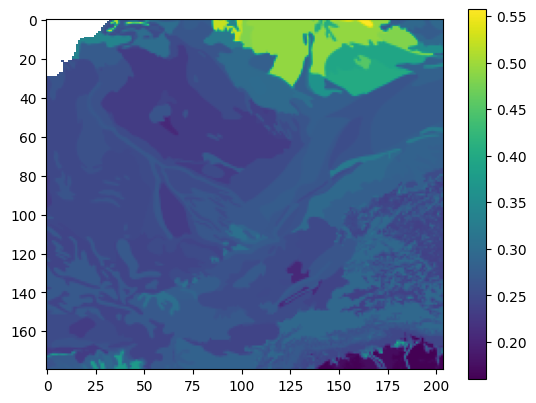

In [13]:
theta_wp = vic_param.variables['Wpwp_FRACT'][:]
plt.imshow(theta_wp[0,:,:])
plt.colorbar()

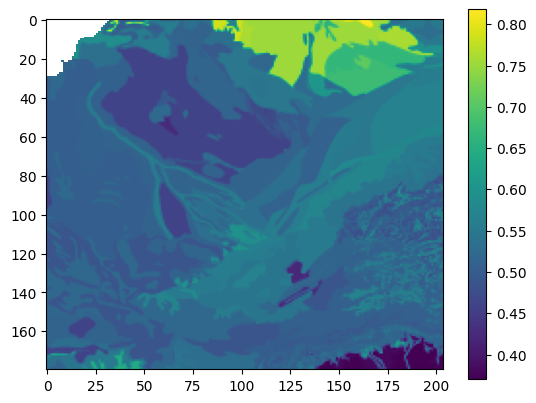

In [14]:
theta_fc = vic_param.variables['Wfc_FRACT'][:]
plt.imshow(theta_fc[0,:,:])
plt.colorbar()

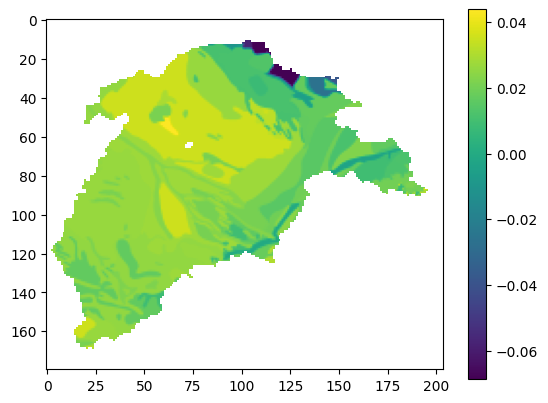

In [15]:
import math
ksatmd = ksat_avg * 24 * 3600 #m/day
b = 0.1068 + 6.547 * 10**(-8) *  ksatmd - 0.31 * theta_wp[2]  #m/d

plt.imshow(b)
plt.colorbar()

inf


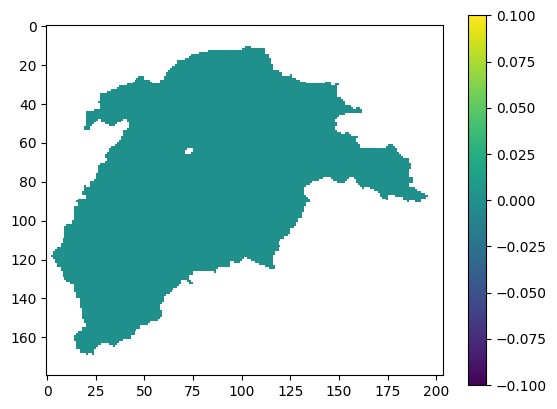

In [16]:
A  = ksatmd *10**-6 * np.exp(5.636+1.326*(10**-6)*ksatmd-0.31*theta_wp[2]) 

denominator = np.exp(10197)
a = A / denominator
print(denominator)

plt.imshow(a)
plt.colorbar()

flux has 15167 non-nan values
max flux is 0.00022746674312864462
min flux is 1.344790691807501e-05
mean flux is 6.558935101730326e-05


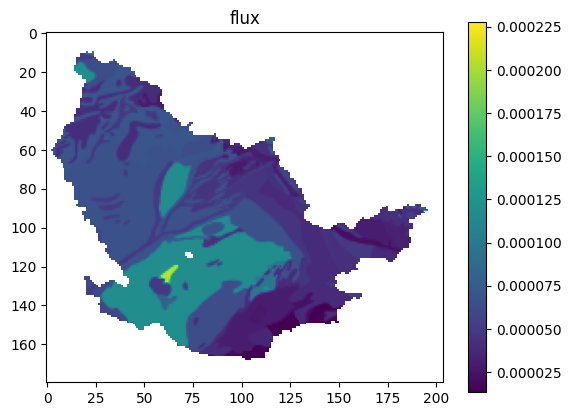

In [17]:
flux = A * np.exp(-b * hc)
flux = np.flip(flux,axis = 0)

#flux = np.ma.masked_array(flux, mask=ksat200_mask)
plt.imshow(flux)
plt.title('flux')
plt.colorbar()
print(f'flux has {np.count_nonzero(~np.isnan(flux))} non-nan values')
print(f'max flux is {np.nanmax(flux)}')
print(f'min flux is {np.nanmin(flux)}')
print(f'mean flux is {np.nanmean(flux)}')


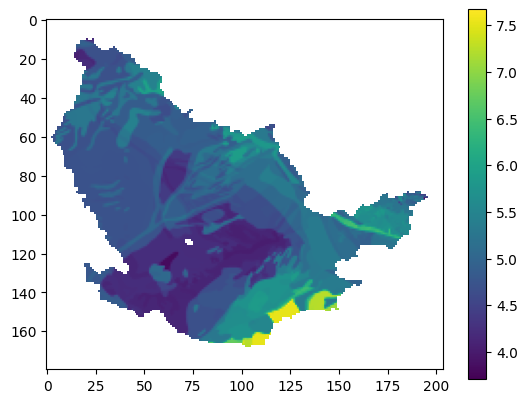

In [18]:

distinction = depth + hc
distinction_masked = np.ma.masked_array(distinction, mask=np.isnan(distinction))

mask = np.flip(domain.variables['mask'][:], axis=0).mask
distinction_masked = np.ma.masked_array(distinction, mask=mask)

distinction= np.flip(distinction_masked, axis = 0)
plt.imshow(distinction)

plt.colorbar()

In [20]:
# this is for createing a temporary constant flux to write to the netcdf file for trial run
import numpy as np
flux.shape
const_array = np.zeros_like(flux)
const_array[~np.isnan(flux)] = 0.0001

In [21]:

import shutil
indus_file_path = '/lustre/nobackup/WUR/ESG/yuan018/99Unuse/domain_Indus.nc'
forcinginputdir ='/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfinput' 
output_file = os.path.join(forcinginputdir, "CPsurface.nc")
shutil.copy(indus_file_path, output_file)

with nc.Dataset(output_file,'a') as ncfile:
    CPsurface_var  = ncfile.createVariable('cpsurface','f4',('lat','lon'))
    CPsurface_var.unit = 'meters'
    CPsurface_var.standard_name = 'capillary rise surface'
    CPsurface_var.long_name = 'capillary rise suface elevation (m), namely the bottom of the VIC soil layer'
    CPsurface_var[:,:] = CPsurface
    Max_rate_var = ncfile.createVariable('max_capillary_flux','f4',('lat','lon'))
    Max_rate_var.unit = 'meters'
    Max_rate_var.standard_name = 'max_capillary_flux'
    Max_rate_var.long_name = 'maximum capillary flux derived from the max capillary height (m/d)'
    Max_rate_var[:,:] = const_array
    distinction_var = ncfile.createVariable('distinction_depth','f4',('lat','lon'))
    distinction_var.unit = 'meters'
    distinction_var.standard_name = 'distinction depth'
    distinction_var.long_name = 'distinction depth when capillary rise = 0 (m)'
    distinction_var[:,:] = distinction


# water balance analysis


In [13]:
import flopy 
import flopy.utils.binaryfile as bf
import os

# load the ccb file
path = '/lustre/nobackup/WUR/ESG/yuan018/87Logbook/try_successful_natural_19682000_0128/2Ltrans_off_1968-01-31.cbb'
bud = bf.CellBudgetFile(path)
#print(bud.get_unique_record_names())
#print(bud.list_records())
#print(bud._unique_package_names())
print(bud.get_times())
print(bud.get_indices())
print(bud.get_data(text = 'FLOW-JA-FACE', totim = 31))

[31.0]
None
[array([[[      0.        ,    1418.85045366,  134916.54811606, ...,
               0.        , -313033.58766292,      -0.        ]]])]


In [14]:
bud.get_unique_package_names()
bud.get_unique_record_names()

[b'          STO-SS',
 b'    FLOW-JA-FACE',
 b'             RIV',
 b'             RCH',
 b'             CHD']

In [15]:
bud.get_data(text = 'RIV', totim = 31)

[rec.array([( 2551,     1, 0.), ( 2552,     2, 0.), ( 2553,     3, 0.),
            ..., (34293, 14474, 0.), (34294, 14475, 0.),
            (34296, 14476, 0.)],
           dtype=[('node', '<i4'), ('node2', '<i4'), ('q', '<f8')])]

In [16]:
bud.get_data(text = 'RCH', totim = 31)

[rec.array([( 2551,     1, 12.5193211 ), ( 2552,     2, 12.5193211 ),
            ( 2553,     3, 12.5193211 ), ..., (34293, 14474,  4.96051065),
            (34294, 14475,  4.96051065), (34296, 14476,  4.96051035)],
           dtype=[('node', '<i4'), ('node2', '<i4'), ('q', '<f8')])]

In [17]:
bud.get_data(text = 'EVT', totim = 31)

Exception: The specified text string is not in the budget file.

dict_keys(['lat', 'lon', 'Band1'])


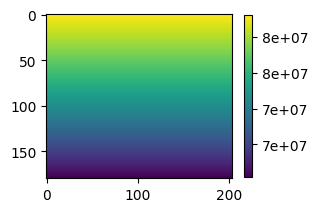

In [ ]:
import netCDF4 as nc
import matplotlib.pyplot as plt
file1 = '/lustre/nobackup/WUR/ESG/yuan018/04Input_Indus/Indus_CellArea_m2_05min.nc'  #deried from global dataset. so no flip is needed
with nc.Dataset(file1, 'r') as ncfile:
    print(ncfile.variables.keys())
    cellarea = ncfile.variables['Band1'][:]
    
plt.figure(figsize=(3, 3))
plt.imshow(cellarea)
plt.colorbar(shrink = 0.7,format='%.0e')


In [18]:
import numpy as np
from matplotlib import pyplot as plt

evt_raw = bud.get_data(text = 'EVT')
evt = [(item['node'],item['q'],item['q']) for item in evt_raw]
ncol, nrow = 204,180
cpr = []
for i in range(len(evt[0][0])):
    idx = evt[0][0][i]
    lay = 0
    row = idx//ncol
    col = idx%ncol-1
    flow = evt[0][2][i]
    rec = [lay,row,col,flow]
    cpr.append(rec)
totalcpr = 0
cpr_array = np.full((nrow, ncol), np.nan)

totalcpr = 0
for item in cpr:
    lay, row, col, flow = item
    totalcpr += flow
    cpr_array[row,col] = flow

cpr_mm = cpr_array/cellarea

# now the unit should be m3/day
print(f'the total cpr is {totalcpr}')
plt.figure(figsize=(3, 3))
plt.imshow(cpr_mm)
plt.colorbar(shrink= 0.7)


Exception: The specified text string is not in the budget file.

the total rch is 557913.4295104205
total net rch is -55348922.37041905


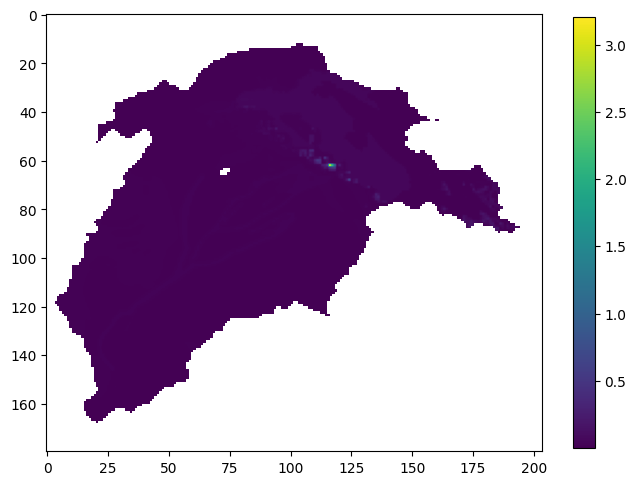

In [19]:
rch_raw = bud.get_data(text = 'RCH', totim = 31)
rch1 =  [(item['node'],item['q'],item['q']) for item in rch_raw]
ncol, nrow = 204,180
rch = []
for i in range(len(rch1[0][0])):
    idx = rch1[0][0][i]
    lay = 0
    row = idx//ncol
    col = idx%ncol-1
    flow = rch1[0][2][i]
    rec = [lay,row,col,flow]
    rch.append(rec)
totalrch = 0
rch_array = np.full((nrow, ncol), np.nan)

totalrch = 0
for item in rch:
    lay, row, col, flow = item
    totalrch += flow
    rch_array[row,col] = flow

rch_mm = rch_array/cellarea
totalnetrch = totalrch+totalcpr
# now the unit should be m3/day???? or m3/month
print(f'the total rch is {totalrch}')
print(f'total net rch is {totalnetrch}')
plt.figure(figsize=(8, 8))
plt.imshow(rch_mm*1000*31)

plt.colorbar(shrink= 0.7)



# testing script for updating statefile

In [30]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [31]:
param_file = '/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/04Forcing/02HumanImpact/coverage_monthly_MIRCA/coverage_monthly_MIRCA_1968.nc'
max_moist_file = '/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_derived_param_for_coupling.nc'
#read the parameter file to get the fraction for each veg class
with nc.Dataset(param_file,'r') as param:
    veg_class_fraction = param.variables['coverage'][1,:,:,:]

with nc.Dataset(max_moist_file,'r') as max_moist:
    max_moisture = max_moist.variables['max_moist'][:]

In [32]:
print(veg_class_fraction.shape)
print(max_moisture.shape)

veg_class_fraction = np.flip(veg_class_fraction,axis = 1)
max_moisture = np.flip(max_moisture,axis = 1)

(22, 180, 204)
(3, 180, 204)


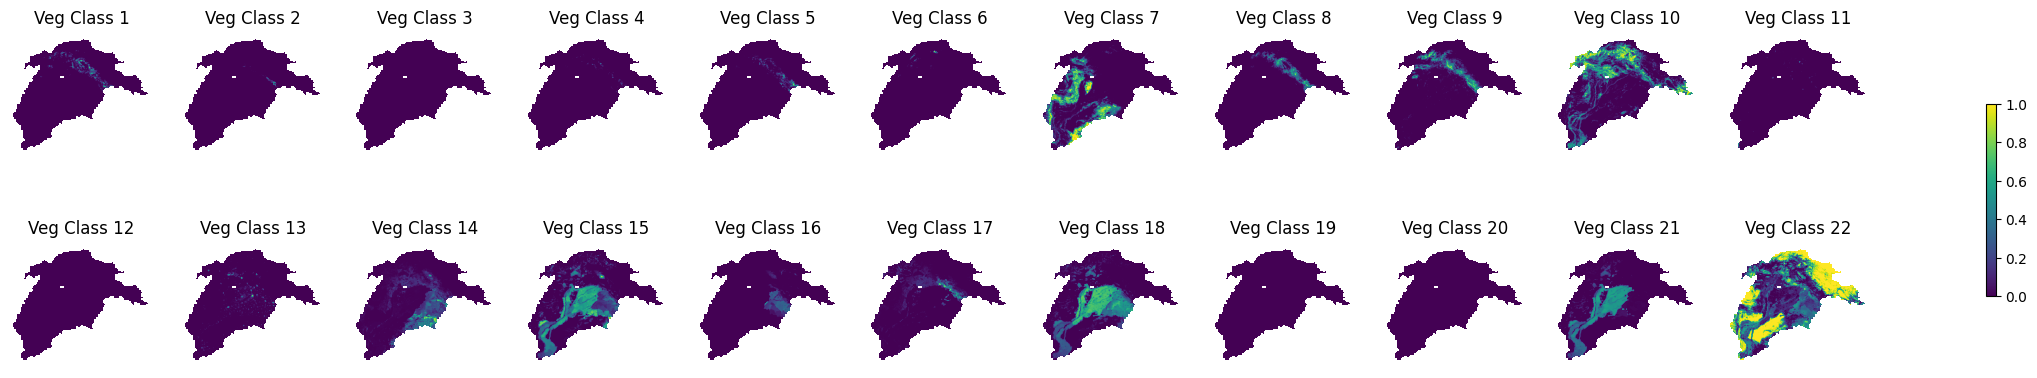

In [33]:
# plot all veg_class_fraction in one subplots
fig, ax = plt.subplots(2, 11, figsize=(30, 5))

for i in range(22):
    veg_class_fraction[i, :, :][mask] = np.nan
    im = ax[i // 11, i % 11].imshow(veg_class_fraction[i, :, :])
    ax[i // 11, i % 11].set_title(f'Veg Class {i + 1}')
    ax[i // 11, i % 11].axis('off')

# Add a colorbar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
plt.show()

veg_class_fraction_sum has 36720 non-nan values
max veg_class_fraction_sum is 1.0000001192092896
min veg_class_fraction_sum is 0.0
unique values of veg_class_fraction_sum is [0.0 0.9999998807907104 0.9999999403953552 1.0 1.0000001192092896]


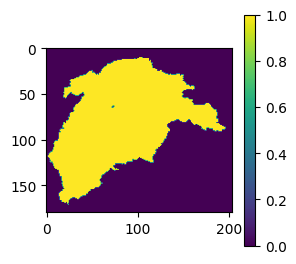

In [34]:
#check if the fraction of all veg class sum up to 1
veg_class_fraction_sum = np.nansum(veg_class_fraction,axis = 0)
plt.figure(figsize = (3,3))
plt.imshow(veg_class_fraction_sum)
plt.colorbar()
print(f'veg_class_fraction_sum has {np.count_nonzero(~np.isnan(veg_class_fraction_sum))} non-nan values')
print(f'max veg_class_fraction_sum is {np.nanmax(veg_class_fraction_sum)}')
print(f'min veg_class_fraction_sum is {np.nanmin(veg_class_fraction_sum)}')
#check if there is any value that is not 0 or 1
print(f'unique values of veg_class_fraction_sum is {np.unique(veg_class_fraction_sum)}')

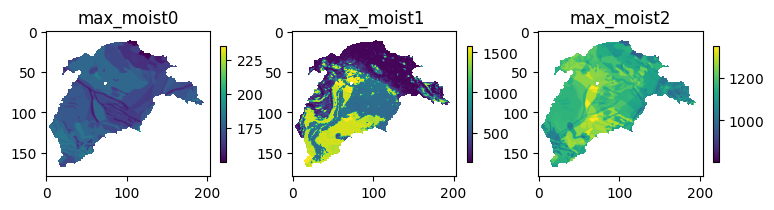

In [35]:
# plot maxmoist in one subplots
fig1, ax1 = plt.subplots(1,3, figsize=(9,3))
                        
for i in range(3):
    max_moisture[i][mask] = np.nan
    
    ax1[i].imshow(max_moisture[i,:,:])
    ax1[i].set_title(f'max_moist{i}')
    fig1.colorbar(ax1[i].imshow(max_moisture[i,:,:]), ax=ax1[i], orientation='vertical',  format=ticker.ScalarFormatter(useMathText=True),shrink=0.5  )
plt.show()

(180, 204)
(22, 180, 204)


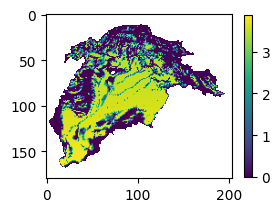

In [36]:
#prepare a test array for capillary rise flux
cpr_mm_month = -1* cpr_mm * 31 *1000 #from m to mm
print(cpr_mm_month.shape)
plt.figure(figsize = (3,3))
plt.imshow(cpr_mm_month)
plt.colorbar(shrink = 0.7)
cpr_mm_month_input = np.repeat(cpr_mm_month[np.newaxis,:,:],22,axis = 0)

print(cpr_mm_month_input.shape)

In [37]:
# Read the state file
#statefile_dir = config.paths.statefile_dir
state_file = '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/statefile/state_file_.19680201_00000.nc'
with nc.Dataset(state_file,'r') as state:
    state_soil_moisture = state.variables['STATE_SOIL_MOISTURE'][:,0,:,:,:]
    state_soil_moisture = np.flip(state_soil_moisture,axis = 2)
print(state_soil_moisture.shape)

(22, 3, 180, 204)


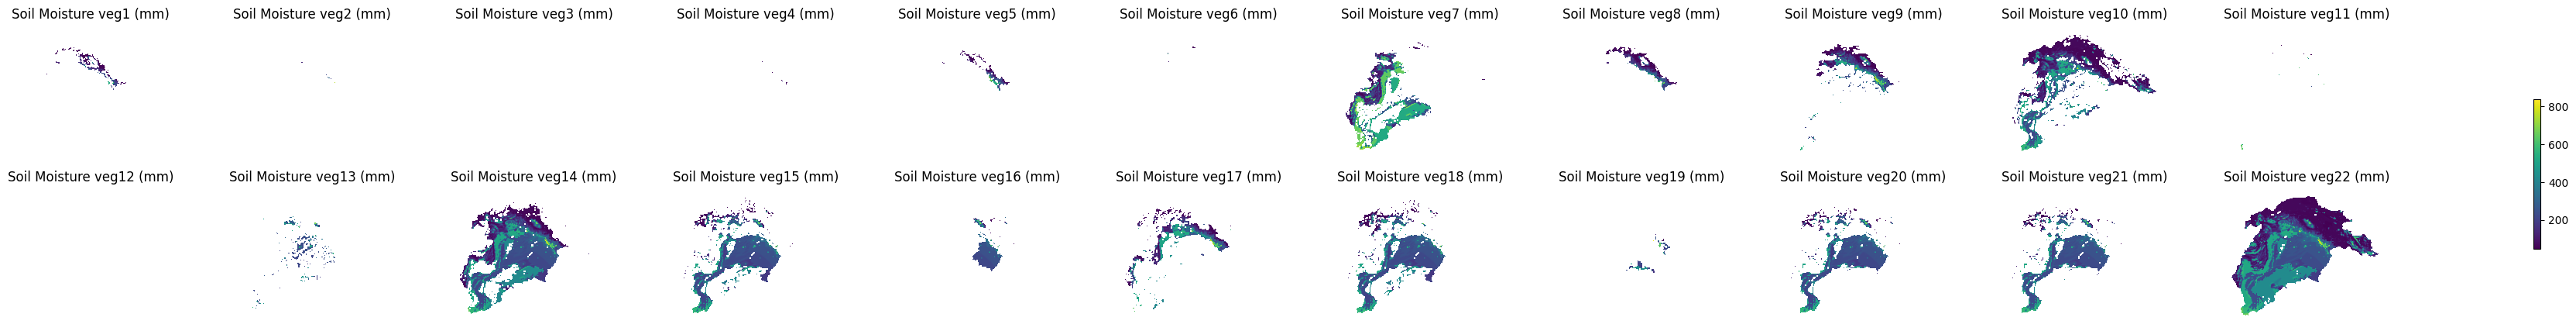

(22, 180, 204)


In [38]:
# plot all veg_class_fraction in one subplots
# only for visiualization. not usable. since the soil moisture for each veg type was not fractioned in statefile. 
fig, ax = plt.subplots(2,11, figsize=(50,5))
for i in range(22):
    state_soil_moisture[i,1,:,:][mask] = np.nan
    im = ax[i//11, i%11].imshow(state_soil_moisture[i, 1,:, :])
    ax[i//11, i%11].set_title(f'Soil Moisture veg{i+1} (mm)')
    ax[i//11, i%11].axis('off')

# Add a colorbar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
plt.show()

print(veg_class_fraction.shape)

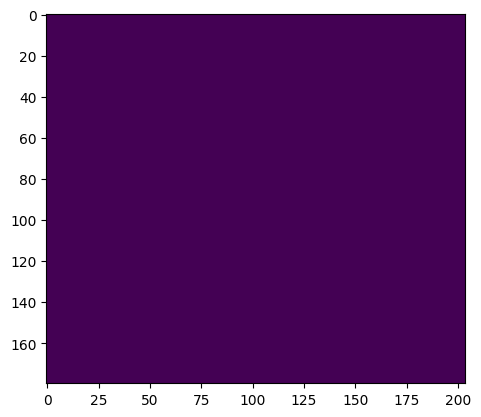

In [39]:
sum_soil_moisture = np.zeros((3, 180, 204))
#state_soil_moisture_new = state_soil_moisture.copy()
#state_soil_moisture_new[:,2,:,:] = state_soil_moisture [:,2,:,:]+ cpr_mm_month_input

all_layers_saturated = True
excess_water = np.zeros((180, 204))
excess_mask = ~np.isnan(excess_water) & (excess_water > 0)

plt.imshow(excess_mask)

In [47]:
#将cpr flux带来的多余moist加到每个vegtype的第三层土壤中
state_soil_moisture_new = state_soil_moisture.copy()
state_soil_moisture_new[:,2,:,:] = state_soil_moisture [:,2,:,:]+ cpr_mm_month_input
#state_soil_moisture_new[:,2,:,:] = state_soil_moisture [:,2,:,:] +500 # for testing saturation condition 
print(state_soil_moisture_new[:, :, :, :].shape)
#准备一个空的3d array来存放每个vegtype加合fraction之后得出的总土壤湿度
sum_soil_moisture = np.zeros((3, 180, 204))



for layer in range(2, -1, -1):  # loop through the soil layers from bottom to top
    sum_soil_moisture[layer] = np.nansum(state_soil_moisture_new[:, layer, :, :] * veg_class_fraction, axis=0) # sum up the soil moisture for each veg type
    #sum_soil_moisture[layer][mask] = np.nan # mask out the non-Indus area

    #check if the soil moist is saturated.  
    checksaturation = (sum_soil_moisture[layer]> max_moisture[layer]) #true if it is saturated
    if checksaturation.any():
        print(f'there are cells in layer {layer+1} saturated')
        excess_water = sum_soil_moisture[layer] - max_moisture[layer]
        excess_water[excess_water<0] = 0
        # let the current layer soil moisture be the max moisture
        for i in range(22):
            state_soil_moisture_new[i, layer, :, :][checksaturation] = max_moisture[layer][checksaturation]
        # add the extra to the upper layer
            if layer > 0:
                state_soil_moisture_new[i, layer-1, :, :][checksaturation] += excess_water[checksaturation]
            else:
                print(f'layer {layer+1} is the top layer, no where to add the excess water')
                        
    else:
        print(f'layer {layer+1} is not saturated')
        break     
    

(22, 3, 180, 204)
layer 3 is not saturated


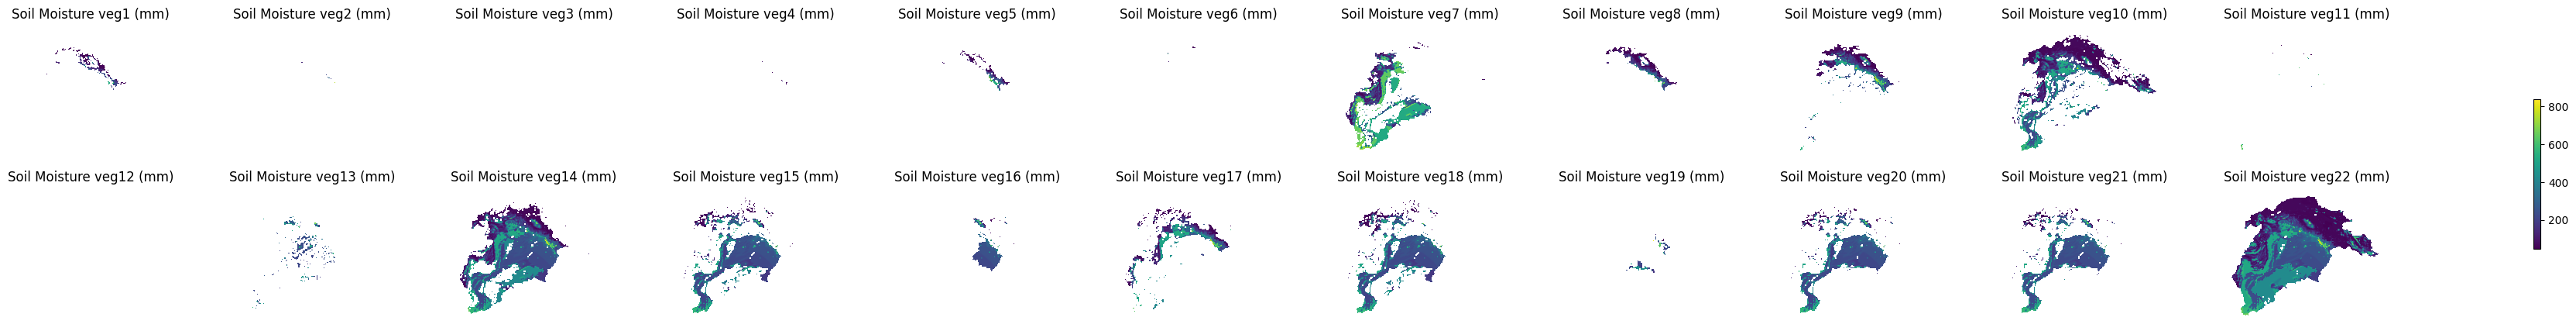

(22, 180, 204)


In [41]:
# plot all veg_class_fraction in one subplots
# only for visiualization. not usable. since the soil moisture for each veg type was not fractioned in statefile. 
fig, ax = plt.subplots(2,11, figsize=(50,5))
for i in range(22):
    state_soil_moisture[i,1,:,:][mask] = np.nan
    im = ax[i//11, i%11].imshow(state_soil_moisture[i, 1,:, :])
    ax[i//11, i%11].set_title(f'Soil Moisture veg{i+1} (mm)')
    ax[i//11, i%11].axis('off')

# Add a colorbar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
plt.show()

print(veg_class_fraction.shape)

In [35]:
import netCDF4 as nc
import numpy as np
#check difference
state_file =  '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/statefile/state_file_.19680201_00000_original.nc'
sate_filenew = '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/statefile/state_file_.19680201_00000.nc'

with nc.Dataset(state_file,'r') as state:
    state_soil_moisture_1 = state.variables['STATE_SOIL_MOISTURE'][:,0,2,:,:]
    state_soil_moisture_1 = np.flip(state_soil_moisture_1,axis = 1)



In [36]:

with nc.Dataset(sate_filenew,'r') as state:
    state_soil_moisture = state.variables['STATE_SOIL_MOISTURE'][:,0,2,:,:]
    state_soil_moisture = np.flip(state_soil_moisture,axis = 1)

In [37]:
diff=(state_soil_moisture_1-state_soil_moisture)
print(diff.shape)

(22, 180, 204)


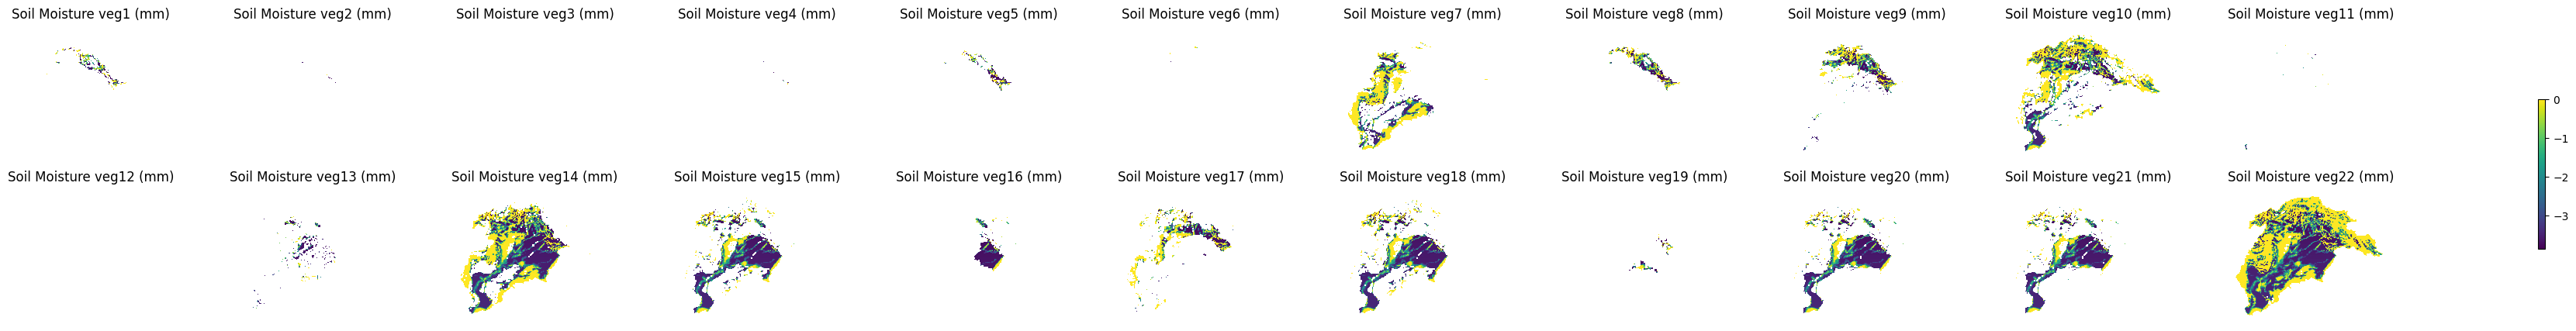

In [38]:
from matplotlib import pyplot as plt
# plot all veg_class_fraction in one subplots
# only for visiualization. not usable. since the soil moisture for each veg type was not fractioned in statefile. 
fig, ax = plt.subplots(2,11, figsize=(50,5))
for i in range(22):

    im = ax[i//11, i%11].imshow(diff[i, :, :])
    ax[i//11, i%11].set_title(f'Soil Moisture veg{i+1} (mm)')
    ax[i//11, i%11].axis('off')

# Add a colorbar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
plt.show()

